In [1]:
import pandas as pd
import numpy as np
import os
import random
import deepchem as dc
import tensorflow as tf

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'


This module requires PyTorch to be installed.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
#Importing ESOL Delaney solubility dataset 

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer="GraphConv", splitter="random")
train_dataset, valid_dataset, test_dataset = datasets
train_dataframe = train_dataset.to_dataframe()
print(train_dataframe.head)

<bound method NDFrame.head of                                                      X         y    w  \
0    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.038124  1.0   
1    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.210134  1.0   
2    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.151537  1.0   
3    <deepchem.feat.mol_graphs.ConvMol object at 0x... -0.764750  1.0   
4    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.283853  1.0   
..                                                 ...       ...  ...   
897  <deepchem.feat.mol_graphs.ConvMol object at 0x... -0.694339  1.0   
898  <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.272512  1.0   
899  <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.884000  1.0   
900  <deepchem.feat.mol_graphs.ConvMol object at 0x... -0.292666  1.0   
901  <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.789489  1.0   

                                           ids  
0               CN(C)C(=O)C(c1ccccc1)c2ccccc

In [5]:
#Featurise data

from rdkit import Chem

featurizer = dc.feat.CircularFingerprint(size=2048, radius=4)
X = featurizer.featurize(train_dataframe["ids"])
y = train_dataframe["y"] #Solubility 
smiles = train_dataframe["ids"]

[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerator
[18:04:48] DEPRECATION WARNING: please use MorganGenerat

In [6]:
#Train test split 

from sklearn.model_selection import train_test_split
seed = random.seed(400)
X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(X, y, smiles, test_size=0.2, random_state=seed)

In [7]:
#Train the model

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

reg = GradientBoostingRegressor(random_state=seed)
reg.fit(X_train, y_train)
print(cross_val_score(reg, X_train, y_train, cv=3, n_jobs=-1).mean())

0.5740831615505723


In [ ]:
#Optional Optimisation

param_grid = {
    "n_estimators": [10, 50, 100, 500],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "max_depth":[3, 5, 7, 9],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "min_samples_split": [2, 4, 6, 8, 10], 
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0]
}

reg2 = GridSearchCV(reg, param_grid, cv=3, n_jobs=-1)

search = RandomizedSearchCV(reg, param_distributions= param_grid, n_iter=100, cv=3, n_jobs=-1, verbose=2)
search.fit(X_train, y_train)

print(f"Best Training Parametres: {search.best_params_}")
print(f"Best Training Score: {search.best_score_}")

In [8]:
#Actual Test data 

test_param_grid = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    "max_depth":[7],
    "min_samples_leaf": [4],
    "min_samples_split": [6], 
    "subsample": [0.7]
}

test_regression = GridSearchCV(reg, test_param_grid, cv=3, n_jobs=-1)
test_regression.fit(X_test, y_test)

print(f"Best Test Score: {test_regression.best_score_}")

Best Test Score: 0.3844526772494595


In [17]:
#Creating dataframes

test_data = {"Predicted Solubility logS [mol/L]" : test_regression.predict(X_test), 
             "Actual Solubility logS [mol/L]" : y_test, 
             "SMILES" : smiles_test
            }

test_data["Residuals"] = test_data["Predicted Solubility logS [mol/L]"] - test_data["Actual Solubility logS [mol/L]"]
test_dataframe = pd.DataFrame(data=test_data)

train_data = {"Predicted Solubility logS [mol/L]" : reg.predict(X_train), 
              "Actual Solubility logS [mol/L]" : y_train,
              "SMILES" : smiles_train
             }

train_data["Residuals"] = train_data["Predicted Solubility logS [mol/L]"] - train_data["Actual Solubility logS [mol/L]"]
train_dataframe = pd.DataFrame(data=train_data)

In [20]:
#Calculating Scores

from sklearn import metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

predicted_RMSE = root_mean_squared_error(test_dataframe["Predicted Solubility logS [mol/L]"], test_dataframe["Actual Solubility logS [mol/L]"])
predicted_r2_score = r2_score(test_dataframe["Predicted Solubility logS [mol/L]"], test_dataframe["Actual Solubility logS [mol/L]"])
print(f"The predicted RMSE is: {predicted_RMSE}")
print(f"The predicted R2 score is: {predicted_r2_score}")

The predicted RMSE is: 0.0378110238581379
The predicted R2 score is: 0.9985556045650252


Text(0.9, 0.2, 'R-squared = 0.999\nRMSE = 0.038')

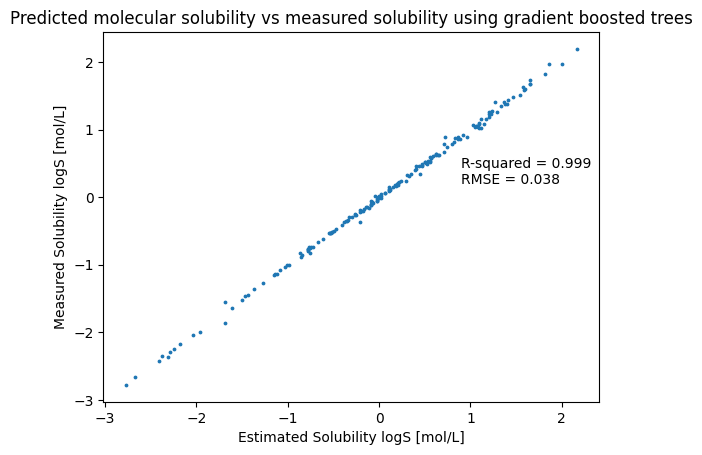

In [21]:
#Scatter graph 

import matplotlib.pyplot as plt
import numpy as np

plt.scatter(test_dataframe["Predicted Solubility logS [mol/L]"], test_dataframe["Actual Solubility logS [mol/L]"], s=3) #x, y
plt.title("Predicted molecular solubility vs measured solubility using gradient boosted trees")
plt.xlabel("Estimated Solubility logS [mol/L]")
plt.ylabel("Measured Solubility logS [mol/L]")
plt.text(0.9, 0.2, 'R-squared = %.3f\nRMSE = %.3f' % (predicted_r2_score, predicted_RMSE))

Text(0, 0.5, 'Residuals (Predicted - Actual)')

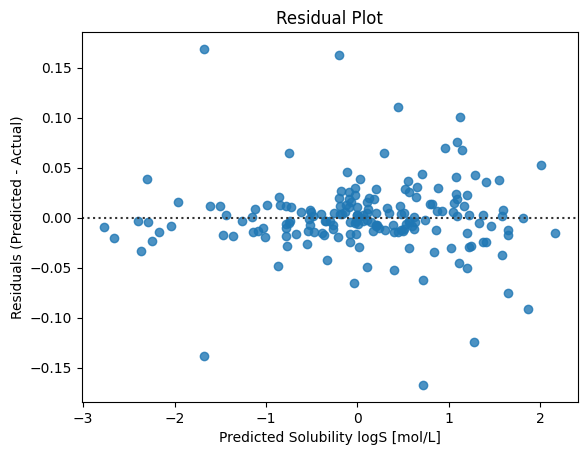

In [24]:
#Residual Plot 

import seaborn as sns

sns.residplot(x=test_dataframe["Predicted Solubility logS [mol/L]"], y=test_dataframe["Residuals"])
plt.title("Residual Plot")
plt.xlabel("Predicted Solubility logS [mol/L]")
plt.ylabel("Residuals (Predicted - Actual)")

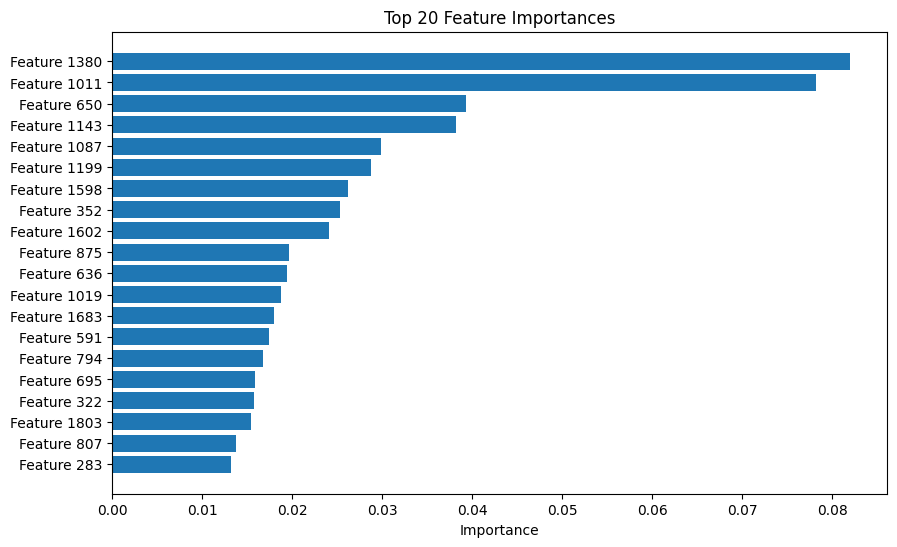

In [25]:
#Feature importance

best_model = test_regression.best_estimator_ #Get trained model with best hyperparametres 
importances = best_model.feature_importances_ #GB assigns numerical importance to each feature
X_train_df = pd.DataFrame(X_train, columns=[f"Feature {i}" for i in range(X_train.shape[1])])
feature_names = X_train_df.columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'][:20], feat_imp_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()